# Recap

In the lecture, we covered the basic knowledge of sequence modelling and Attention mechanism.

## **I. Sequence Modelling**

### Overview: RNN vs.LSTM vs. GRU

| Model | Description | Disadvantages |
|-------|-------------|---------------|
| **RNN** | Output depends on previous elements in the sequence. | Struggles with long-term dependencies due to vanishing<br> gradients, limiting its ability to learn long-range relationships. |
| **LSTM** | Capable of handling long-term dependencies using<br> memory cells and gates to control information flow. | Computationally expensive due to its complex architecture. |
| **GRU** | A simpler version of LSTM with fewer gates, making it<br> faster and computationally lighter while maintaining<br> similar performance for certain tasks. | Can be less effective for very complex tasks compared to LSTM. |


### Visual: Sequential Computation in RNNs

![RNN Unfolded](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png)

- RNNs process inputs **one step at a time**, which limits parallelism and makes training slow.

## **II. The Rise of Transformers**

Traditional sequence models process tokens **sequentially**. Transformers introduced **self-attention**, enabling **parallel computation** and better handling of long-term dependencies.

![s](MEME.jpeg)
### Visual: Self-Attention Enables Global Context

![Self-Attention](https://jalammar.github.io/images/t/transformer_self-attention_visualization.png)

- Each token attends to all other tokens, capturing **global context** in one step.

- ## **III. Transformer Architecture Evolution**

### **Original: Encoder-Decoder Transformer (2017)**

![Encoder-Decoder Architecture](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)

- **Encoder**: Processes the input.
- **Decoder**: Generates output by attending to both prior outputs and encoder outputs.

**Use Cases**: Translation, summarization, question answering.

### **Modern: Decoder-Only (GPT-style)**


- **One stack of decoder blocks**
- Learns to generate the next token given all previous tokens (causal attention).
- Pretraining is done on raw text; no encoder needed.

**Use Cases**: Text generation, chatbots, code generation, instruction following.





## **II. Attention Mechanism**



The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers, including *Scaled dot product attention* and *Multi-head attention*.'

### Types of Attention

- Global/Local Attention:
    - Global: attend all encoder hidden states, captures long-range dependencies and overall context.
    - Local: focus on a subset of encoder hidden states.
- Hard/Soft Attention
    - Hard: rely on a singe encoder hidden state.:
    - Soft: focus on different parts of the input with varying degrees of emphasis.
- Self/Multi-head Attention:
    - Self-attention: allow elements in an entire sequence to attend to all other elements in the same sequence, not just the element next to it.
    - Multi-head attention: apply the self-attention several times in parallel.


![Encoder-decoder](https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png)

### Advantages

A transformer model handles variable-sized input using stacks of self-attention layers instead of RNN or CNN. This general architecture has a number of advantages:
- Layer outputs can be calculated in parallel, instead of a series like an RNN.
- Distant items can affect each other's output without passing through many RNN-steps, or convolution layers.
- It can learn long-range dependencies. This is a challenge in many sequence tasks.

### Disadvantages

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
- If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words.
- squared complexity.

# Coding demo

Reference: [transformer from scratch](https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import matplotlib.pyplot as plt
import numpy as np

## Positional Encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

$$ {PE_{(pos, 2i)} = sin(pos * C^{-2i / d_{model}})} $$
$$ {PE_{(pos, 2i+1)} = cos(pos * C^{-2i / d_{model}})} $$

where C = 10000.

Transforming the formulas:

$$ {log ( C^{-2i/d_{model}}) = -(2i/d_{model}) * log(C) = 2i * (-log(C) / d_{model})} $$
Then, $$  C^{{-2i}/{d_{model}}} = \exp\left( 2i \cdot \frac{-\log(C)}{d_{model}} \right) $$

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_embedding, max_len=5000):
        super(PositionalEncoding, self).__init__()
        positional_encodings = torch.zeros(max_len, dim_embedding)
        positions = torch.arange(0, max_len).unsqueeze(1).float()

        # calculate the arguments for sin and cos functions
        scale = -(math.log(10000) / dim_embedding)
        arguments = torch.arange(0, dim_embedding, 2).float() * scale
        arguments = torch.exp(arguments)
        arguments = positions * arguments

        # define the encodings here
        positional_encodings[:, 0::2] = torch.sin(arguments)
        positional_encodings[:, 1::2] = torch.cos(arguments)

        positional_encodings = positional_encodings.unsqueeze(0)
        self.register_buffer('positional_encodings', positional_encodings)

    def forward(self, x):
        pos_enc = self.positional_encodings[:, :x.size(1)]
        pos_enc.requires_grad_(False)
        x  = x + pos_enc
        return x

Visualize Positional Encoding

In [3]:
torch.Tensor([i for i in range(100)])

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97.,
        98., 99.])

<Figure size 1500x500 with 0 Axes>

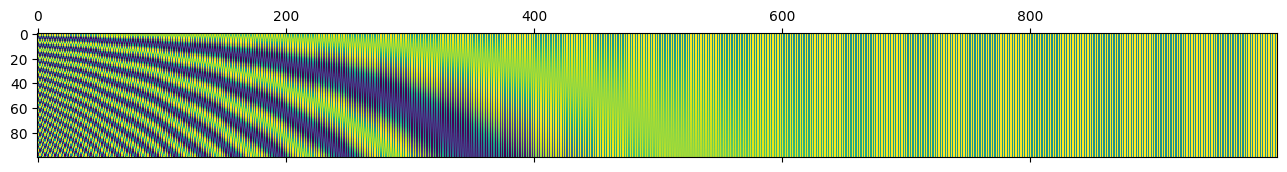

In [4]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(1000)
y = pe(torch.zeros(1, 100, 1000))
# plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
# plt.legend(["dim %d"%p for p in [4, 5, 6, 7]])
plt.matshow(y.squeeze(0))

## Encoder

The encoder of Transformer and its Multi-head attention are shown below:

<center><img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width="200" />
<img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" width="200" /><center>

We build these block seperately, including Mutli-Head Attention, Feedforward,and combine them as an Encoder

### Multihead Attention Module

In [5]:
# Encoder: Step-by-step computation of Q, K, V
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = nhead

        self.d_k = d_model // nhead

        self.query_weight = nn.Linear(d_model, d_model)
        self.key_weight = nn.Linear(d_model, d_model)
        self.value_weight = nn.Linear(d_model, d_model)
        self.out_weight = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Following the formula Q * K / sqrt(d). Slide 30 Lecture Notes
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # Write a very low value (indicating -inf) to the positions where mask == 0
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        # Take the softmax and multiply V
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.query_weight(Q))
        K = self.split_heads(self.key_weight(K))
        V = self.split_heads(self.value_weight(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.out_weight(self.combine_heads(attn_output))
        return output

### Feedforward Module

In [6]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

### The Encoder Block

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Multi-head Attention
        attn_output = self.self_attn(x, x, x, mask)
        # Add and Norm
        x = self.norm1(x + self.dropout(attn_output))
        # Feedforward
        ff_output = self.feed_forward(x)
        # Add and Norm
        x = self.norm2(x + self.dropout(ff_output))
        return x

## Decoder

The Decoder of Transformer is shown below. Since we already have all the building blocks, we just need to put them in the correct order

<center><img src="https://miro.medium.com/v2/resize:fit:552/format:webp/0*SPZgT4k8GQi37H__.png" width="150" /> <center>

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        # Masked Multi-head Attention
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # Multi-head Attention with inputs from the Encoder
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        # Feed forward
        self.feed_forward = FeedForward(d_model, d_ff)
        # Add and norm layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Masked Multi-head Attention
        attn_output = self.self_attn(x, x, x, tgt_mask)
        # Add and norm
        x = self.norm1(x + self.dropout(attn_output))
        # Multi-head Attention with inputs from the Encoder
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        # Add and norm
        x = self.norm2(x + self.dropout(attn_output))
        # Feedforward
        ff_output = self.feed_forward(x)
        # Add and norm
        x = self.norm3(x + self.dropout(ff_output))
        return x

## Transformer



Now that we have the Encoder and the Decoder, we can put them together to create a complete Transformer

<center><img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" alt="Alternative text" width="400" height="500"/></center>
<center><figcaption>Fig 2. Transformer Encoder."https://arxiv.org/pdf/2010.11929.pdf. </figcaption></center>  




In [9]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_len, dropout, device):
        super(Transformer, self).__init__()
        self.device = device
        # Encoder input embedding
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        # Decoder input embedding
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        # Multiple encoders and decoders
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        # Last linear layer at the output of decoder
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(self.device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # Create positional encoding
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        # Feed to the encoders sequentially
        for encoder_layer in self.encoder_layers:
            enc_output = encoder_layer(enc_output, src_mask)

        # Feed to the decoders sequentially
        dec_output = tgt_embedded
        for decoder_layer in self.decoder_layers:
            dec_output = decoder_layer(dec_output, enc_output, src_mask, tgt_mask)

        # Last linear layer
        output = self.fc(dec_output)
        return output

## Train with real text

In [11]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import urllib.request
from pickle import load
import os
from random import shuffle

### Download the dataset

In [12]:
def download_dataset(url, local_filename):
    if not os.path.exists(local_filename):
        urllib.request.urlretrieve(url, local_filename)
    return local_filename

### Simple Tokennizer

There are many tokenizer techniques. In this demo, we use a simple tokenizer by utilizing the order that a word appear in the dataset.

In [13]:
class SimpleTokenizer:
    def __init__(self):
        self.word2idx = {'<PAD>': 0}
        self.idx2word = {0: '<PAD>'}

    def fit(self, texts):
        idx = 1
        for sentence in texts:
            for word in sentence.strip().split():
                if word not in self.word2idx:
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word
                    idx += 1

    def encode(self, text):
        return [self.word2idx.get(w, 0) for w in text.strip().split()]

    def __len__(self):
        return len(self.word2idx)

### Dataset class

In [14]:
class TranslationDataset(Dataset):
    def __init__(self, data_pairs, src_tokenizer, tgt_tokenizer):
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.src_data = [torch.tensor(src_tokenizer.encode(pair[0]), dtype=torch.long) for pair in data_pairs]
        self.tgt_data = [torch.tensor(tgt_tokenizer.encode(pair[1]), dtype=torch.long) for pair in data_pairs]

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]

### Prepare the dataset

In [15]:
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

In [16]:
def prepare_dataloaders(n_samples=500, batch_size=32):
    # Download and load
    url = "https://github.com/Rishav09/Neural-Machine-Translation-System/raw/master/english-german-both.pkl"
    filename = download_dataset(url, "eng-ger.pkl")

    with open(filename, "rb") as f:
        data = load(f)

    data = data[:n_samples]
    for i in range(n_samples):
        data[i][0] = "<START> " + data[i][0] + " <EOS>"
        data[i][1] = "<START> " + data[i][1] + " <EOS>"

    shuffle(data)
    split = int(0.9 * n_samples)
    train_data, val_data = data[:split], data[split:]

    # Tokenizers
    src_tokenizer = SimpleTokenizer()
    tgt_tokenizer = SimpleTokenizer()
    src_tokenizer.fit([pair[0] for pair in train_data])
    tgt_tokenizer.fit([pair[1] for pair in train_data])

    # Datasets
    train_ds = TranslationDataset(train_data, src_tokenizer, tgt_tokenizer)
    val_ds = TranslationDataset(val_data, src_tokenizer, tgt_tokenizer)

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, len(src_tokenizer), len(tgt_tokenizer), src_tokenizer, tgt_tokenizer

In [17]:
# prep = PrepareDataset()
train_loader, val_loader, src_len, tgt_len, src_tokenizer, tgt_tokenizer = prepare_dataloaders()

src_len, tgt_len

(308, 356)

### Model parameters and initialization

In [29]:
src_vocab_size = 500
tgt_vocab_size = 500
d_model = 512
num_heads = 8
num_layers = 4
d_ff = 2048
max_seq_length = 100
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100

In [30]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, device)
transformer = transformer.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=1e-4)

### Training loop

In [31]:
for epoch in range(epochs):
    transformer.train()
    total_loss = 0
    for src_batch, tgt_batch in train_loader:
        src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)

        # Prepare decoder input and target
        dec_input = tgt_batch[:, :-1]
        target = tgt_batch[:, 1:]

        output = transformer(src_batch, dec_input)
        output = output.reshape(-1, output.size(-1))
        target = target.reshape(-1)

        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validate
    transformer.eval()
    val_loss = 0

    with torch.no_grad():
        for src_batch, tgt_batch in val_loader:
            src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)

            # Prepare decoder input and target
            dec_input = tgt_batch[:, :-1]
            target = tgt_batch[:, 1:]

            output = transformer(src_batch, dec_input)
            output = output.reshape(-1, output.size(-1))
            target = target.reshape(-1)

            loss = criterion(output, target)
            val_loss += loss.item()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Train loss: {total_loss:.4f}, Val loss: {val_loss:.4f}")


Epoch 1, Train loss: 71.3920, Val loss: 7.7469
Epoch 10, Train loss: 8.3531, Val loss: 3.6410
Epoch 20, Train loss: 1.5712, Val loss: 3.3151
Epoch 30, Train loss: 1.0458, Val loss: 3.5669
Epoch 40, Train loss: 0.5040, Val loss: 3.4192
Epoch 50, Train loss: 0.3037, Val loss: 3.5391
Epoch 60, Train loss: 0.3418, Val loss: 3.6895
Epoch 70, Train loss: 0.2591, Val loss: 3.1907
Epoch 80, Train loss: 0.1893, Val loss: 3.2875
Epoch 90, Train loss: 0.1564, Val loss: 3.3542
Epoch 100, Train loss: 0.1619, Val loss: 3.4086


## Predict on validation text

In [33]:
def decode_sequence(tensor, tokenizer):
    # Inverse map from token index to word
    idx2word = {idx: word for word, idx in tokenizer.word2idx.items()}
    idx2word[0] = "<PAD>"
    return ' '.join([idx2word.get(idx.item(), '') for idx in tensor if idx.item() != 0])

# Get one batch
transformer.eval()
src_batch, tgt_batch = next(iter(val_loader))
src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)

with torch.no_grad():
    dec_input = tgt_batch[:, :-1]
    output = transformer(src_batch, dec_input)
    pred = output.argmax(dim=-1)

# Decode example 0
print(src_batch[0], tgt_batch[0], pred[0])
src_sentence = decode_sequence(src_batch[0], src_tokenizer)
true_tgt = decode_sequence(tgt_batch[0], tgt_tokenizer)
predicted_tgt = decode_sequence(pred[0], tgt_tokenizer)

print("SRC:", src_sentence)
print("TRUE TGT:", true_tgt)
print("PREDICTED TGT:", predicted_tgt)


tensor([  1, 194, 195,   5,   0,   0,   0], device='cuda:0') tensor([  1, 206, 200,   5,   0,   0,   0,   0], device='cuda:0') tensor([206, 200,   5,   5,   5,   5,   5], device='cuda:0')
SRC: <START> keep walking <EOS>
TRUE TGT: <START> geht weiter <EOS>
PREDICTED TGT: geht weiter <EOS> <EOS> <EOS> <EOS> <EOS>


# Your Task - Vision Transformer

Instead of applying the Transformer to languages, you will adapt the code to vision domain. The dataset used are MNIST and Fashion-MNIST. Consider the following steps to complete the assignment:

1. Since a single image is *2 dimensional*, first you have to create a sequence by extracting <font color='red'>patches</font> from an image.

<img src="https://www.mdpi.com/mti/mti-06-00111/article_deploy/html/images/mti-06-00111-g001-550.jpg" width="600"/>


2. Use a linear layer to obtain a vector or patch embedding.

3. The position of the patch is also transformed into a vector by "position encoding"

4. Create the Transformer with Multi-head Attention, Norm and MLP blocks.

This GIF below might help with your implementation. Source: [ViT](https://en.wikipedia.org/wiki/Vision_transformer)


<!-- <center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Vision_Transformer.svg/1280px-Vision_Transformer.svg.png" with="600"/><center> -->

<center><img src="https://upload.wikimedia.org/wikipedia/commons/3/3e/Vision_Transformer.gif" with="600"/><center>






# GOOD LUCK 🍀